In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from flash_attn import flash_attn_func

from library import StockUniverse, FactorLibrary, MarketInfo, FileLoader





class MarketGuidedGating(nn.Module):
    def __init__(self, market_dim, feature_dim, beta=5):
        super().__init__()
        self.fc = nn.Linear(market_dim, feature_dim)
        self.beta = beta
        self.feature_dim = feature_dim

    def forward(self, x, m):
        alpha = self.feature_dim * F.softmax(self.fc(m) / self.beta, dim=-1)
        return x * alpha  # Hadamard product


class IntraStockEncoder(nn.Module):  # MAX_LEN屬於 time step 系列
    def __init__(self, feature_dim, embed_dim=256, nhead=4, max_len=60): #檢查 embed_dim=256, nhead=4, max_len=60是否正確
        super().__init__()
        self.input_proj = nn.Linear(feature_dim, embed_dim)
        self.register_buffer('pos_encoder', self._get_sinusoid_encoding_table(max_len, embed_dim))  # fixed encoding
        self.layer_norm = nn.LayerNorm(embed_dim)  # LN(f(x) + p)
        #self.encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=1)

    def forward(self, x):  # x: (batch, time, extract_proj_feature) extract_proj_feature = feature_dim (for example : Alpha 158)
        batch, time, _ = x.shape
        x = self.input_proj(x)                         # → (batch, time, embed_dim)
        x = x + self.pos_encoder[:time, :].unsqueeze(0)  # broadcast: [1, time, embed_dim]
        x = self.layer_norm(x)
        #print('Intra x shape')
        #print(x.shape)
        #x = self.transformer(x.transpose(0, 1)).transpose(0, 1)
        x = self.transformer(x) # 這裡的輸出是(batch, time, embed_dim) 同一個batch 以及同一支股票 就是h_{u,t} dim=256
        return x  # (batch, time, embed_dim)

    def _get_sinusoid_encoding_table(self, seq_len, d_model): # seq_len = MAX_LEN, d_model = embed_dim
        position = torch.arange(seq_len, dtype=torch.float).unsqueeze(1)  # [seq_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))  # [d_model//2]
        pe = torch.zeros(seq_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term) #要小心對應到的奇偶數不同會報錯，但不會報錯的原因是embed_dim = 256，是偶數
        return pe  # [seq_len, d_model] that is to say [seq_len, embed_dim] or more precisely []


class InterStockAggregator(nn.Module):
    def __init__(self, embed_dim=256, nhead=2): #數字要再確認一下
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=nhead, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, 4*embed_dim),
            nn.ReLU(),
            nn.Linear(4*embed_dim, embed_dim),
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):  # x: (batch, stocks, time, embed_dim)
        batch, stocks, time, embed_dim = x.shape

        # 變形為 (batch * time, stocks, embed_dim)，將時間軸攤平成 batch 維
        # x.permute(0, 2, 1, 3) 變成 (batch, time, stocks, embed_dim)
        x_reshaped = x.permute(0, 2, 1, 3).reshape(batch * time, stocks, embed_dim)

        # MultiheadAttention: 每個時間點的所有股票做 MHA
        # Self attention with residual + LN
        attn_out, _ = self.attn(x_reshaped, x_reshaped, x_reshaped)  # (batch * time, stocks, embed_dim)
        x_attn = self.norm1(attn_out + x_reshaped)

        # Feed Forward with residual + LN
        ffn_out = self.ffn(x_attn)
        out = self.norm2(ffn_out + x_attn)
        

        # 還原形狀為 (batch, stocks, time, embed_dim)
        out = out.view(batch, time, stocks, embed_dim).permute(0, 2, 1, 3)

        return out  # (batch, stocks, time, embed_dim)



class TemporalAggregator(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.w_lambda = nn.Parameter(torch.randn(embed_dim, embed_dim))

    def forward(self, x):  # x: (batch, stocks, time, embed_dim)
        query  = x[:, :, -1, :]  # (batch, stocks, embed_dim)
        scores = torch.einsum('bstf,fd,bsd->bst', x, self.w_lambda, query)
        weights = F.softmax(scores, dim=2)  # (batch, stocks, time)
        output = torch.einsum('bst,bstf->bsf', weights, x)
        return output  # (batch, stocks, embed_dim)


class MASTER(nn.Module):
    def __init__(self, market_dim, feature_dim, embed_dim=256, nhead1=4, nhead2=2, beta=5):
        super().__init__()
        self.gating = MarketGuidedGating(market_dim, feature_dim, beta)
        self.intra_encoder = IntraStockEncoder(feature_dim, embed_dim, nhead1)
        self.inter_agg = InterStockAggregator(embed_dim, nhead2)
        self.temporal_agg = TemporalAggregator(embed_dim)
        self.predictor = nn.Linear(embed_dim, 1)

    def forward(self, x, market):
        # x: (batch, stocks, time, features), market: (batch, market_features)
        batch, stocks, time, features = x.shape

        # ====== Gating ======
        #market_expanded = market.unsqueeze(1).unsqueeze(2).expand(-1, stocks, time, -1)  # (batch, stocks, time, market_features)
        market_expanded = market[ : , None, None, : ].expand(-1, stocks, time, -1)
        #print(f"market expanded shape = {market_expanded.shape}")
        #print(f"x = {x.shape}")
        market_scaled = self.gating(x, market_expanded)  # broadcasting-wise multiplication

        # ====== Intra-Stock Encoder ======
        #print(f"market_scaled shape = {market_scaled.shape}")
        x_flat = market_scaled.view(batch * stocks, time, features)  # (batch*stocks, time, features)
        #print(f"x_flat shape = {x_flat.shape}")
        local_embed = self.intra_encoder(x_flat)  # → (batch*stocks, time, embed_dim)
        local_embed = local_embed.view(batch, stocks, time, -1)  # → (batch, stocks, time, embed_dim)

        # ====== Inter-Stock Aggregation ======
        inter_embed = self.inter_agg(local_embed)  # (batch, stocks, time, embed_dim)

        # ====== Temporal Aggregation ======
        temporal_embed = self.temporal_agg(inter_embed)  # (batch, stocks, embed_dim)
        #print(f"temporal shape = {temporal_embed.shape}")

        # ====== Prediction ======
        out = self.predictor(temporal_embed).squeeze(-1)  # (batch, stocks)
        #print(self.predictor(temporal_embed).shape)
        return out


In [2]:
import pandas as pd
from torch.utils.data import Dataset
import numpy as np
import gc
import torch
from torch.utils.data import DataLoader

In [3]:
class AllDayFactorDataset(Dataset):
    def __init__(self, stock_universe='TWSE'):
        self.multi_df = FileLoader.load(f'Y:\因子回測_江建彰\因子庫{stock_universe}.pkl')
        self.adj_close_df = pd.read_feather(r'Y:\因子回測_江建彰\補上缺值日頻收盤價.ftr')
        self.stock_list = self.get_stock_list(stock_universe)
        
        self.TPEX_df = MarketInfo.TPEX_norm()
        self.RoR_df = (self.adj_close_df.shift(-5) - self.adj_close_df.shift(-1)) / self.adj_close_df.shift(-1)
        self.RoR_df.dropna(axis=0, inplace=True)


        new_ticker_list = self.multi_df.columns.get_level_values('ticker')
        new_ticker_list = new_ticker_list[~new_ticker_list.duplicated()]

        self.stock_list = new_ticker_list
        self.RoR_df = self.RoR_df[self.stock_list]
        # 這裡所有值都包含當天資訊所以要向後移
        self.restrict_range()
        self.check_validility()

        


        

        #self.tensor_factor = self.factor_to_tensor()
        #self.tensor_market = self.TPEX_df.values
        #self.tensor_return = self.RoR_df[self.stock_list]
        #print(f'stock list : {len(self.stock_list)}')
    def check_validility(self):
        ticker_list1 = self.stock_list
        ticker_list2 = self.RoR_df.columns
        ticker_list3 = self.multi_df.columns.get_level_values('ticker')
        ticker_list3 = ticker_list3[~ticker_list3.duplicated()]
        assert len(ticker_list1)==len(ticker_list2)==len(ticker_list3)
        
        BOOL = True
        for i in range(len(ticker_list1)):
            if not (ticker_list1[i]==ticker_list2[i]==ticker_list3[i]):
                BOOL = False
        assert BOOL==True
        

        factor_list = self.multi_df.columns.get_level_values('factor')
        factor_list = factor_list[~factor_list.duplicated()]
        BOOL = True
        for factor_name in factor_list:
            ticker_list4 = self.multi_df.loc[ : , factor_name].columns
            for i in range(len(ticker_list1)):
                if ticker_list1[i]!=ticker_list4[i]:
                    BOOL = False
        assert BOOL==True
        

    def factor_to_tensor(self):
        factor_num = len(self.multi_df.columns.get_level_values('factor').unique())
        time = len(self.TPEX_df.index)
        

       
            
            
                
        """
        剔除因子缺失太多的股票
        
        new_stock_list = []
        for idx, ticker in enumerate(self.stock_list):
            numpy_array = self.multi_df.xs(ticker, axis=1, level='ticker').values
            missing_ratio = np.isnan(numpy_array).sum() / (time*factor_num)
            if(missing_ratio<=0.05):
                new_stock_list.append(ticker)
        self.stock_list = new_stock_list
        """

        """
        轉成向量
        """

        
        factor_name = 'factor1'
        #print(self.multi_df.loc[start_date : end_date, factor_name])

        
        stock_num = len(self.stock_list)
        tensor_factor = np.empty((stock_num, time, factor_num))
        for idx, ticker in enumerate(self.stock_list):
            numpy_array = self.multi_df.xs(ticker, axis=1, level='ticker').ffill().values
            numpy_array = np.nan_to_num(numpy_array, nan=0.0)
            tensor_factor[idx] = numpy_array

        
        
        return tensor_factor

    

    def restrict_range(self, global_start='2020-04-01', global_end='2025-04-09'):
        self.multi_df     = self.multi_df.loc[global_start : global_end]
        self.adj_close_df = self.adj_close_df.loc[global_start : global_end]
        self.TPEX_df      = self.TPEX_df.loc[global_start : global_end]
        self.RoR_df       = self.RoR_df.loc[global_start : global_end]
    
        
        
        
    def get_stock_list(self, stock_univserse):
        if stock_univserse=='TWSE':
            ticker1 = StockUniverse.TWSE() 
        elif stock_univserse=='OTC':
            ticker1 = StockUniverse.OTC()
        elif stock_univserse=='all':
            ticker1 = StockUniverse.all()
            
        
        ticker2 = self.multi_df.columns.get_level_values('ticker')
        ticker3 = self.adj_close_df.columns
        return list(set(ticker1)&set(ticker2)&set(ticker3))


    

In [4]:
class FactorDataset(Dataset):
    def __init__(self, stock_universe='TWSE', mode='train'):
        #multi_df, TPEX_df, RoR_df = self.restrict_data_range(stock_universe, mode)
        self.e = AllDayFactorDataset(stock_universe='TWSE')
        self.stock_list = self.e.stock_list
        multi_df, TPEX_df, RoR_df = self.restrict_data_range(stock_universe, mode)

        
        
        self.tensor_factor = self.get_tensor_factors(multi_df)
        #self.tesnor_factor = self.tesnor_factor.transpose(1,0,2) # (stock, time, factor) -> (time, stock, factor)
        self.tensor_market = TPEX_df.values
        self.tensor_return = RoR_df.values

        self.tensor_factor = self.transform_to_tensor(self.tensor_factor)
        self.tensor_market = self.transform_to_tensor(self.tensor_market)
        self.tensor_return = self.transform_to_tensor(self.tensor_return)




        returns = self.tensor_return.clone()  # shape: [122, 887]
        mean = returns.mean(dim=1, keepdim=True)   # 每天的均值 shape: [122, 1]
        std = returns.std(dim=1, keepdim=True)     # 每天的標準差 shape: [122, 1]
        # 防止除以 0
        std = torch.where(std == 0, torch.tensor(1.0), std)
        self.tensor_return_norm = (returns - mean) / std  # shape: [122, 887]


        self.T = self.tensor_market.shape[0]
        self.lookback = 8
        self.valid_length = self.T - self.lookback

        del self.e
        gc.collect()

        self.TPEX_df = TPEX_df
        self.RoR_df = RoR_df
        
    def transform_to_tensor(self, numpy_array):
        float32_np = numpy_array.astype(np.float32)
        return torch.from_numpy(float32_np)

    def get_tensor_factors(self, multi_df):
        stock_num = len(multi_df.columns.get_level_values('ticker').unique())
        time = len(multi_df.index)
        factor_num = len(multi_df.columns.get_level_values('factor').unique())
        
        tensor_factor = np.empty((stock_num, time, factor_num))
        for idx, ticker in enumerate(self.stock_list):
            numpy_array = multi_df.xs(ticker, axis=1, level='ticker').values
            tensor_factor[idx] = numpy_array

        assert not np.isnan(tensor_factor).any()

        return tensor_factor
        

    def restrict_data_range(self, stock_universe, mode):
        e = AllDayFactorDataset(stock_universe)
        train_ratio, valid_ratio, test_ratio = 0.8, 0.1, 0.1
        total_num = len(self.e.TPEX_df)
        train_num = int(total_num*train_ratio)
        valid_num = int(total_num*valid_ratio)
        test_num  = total_num - (train_num+valid_num)
        if mode=='train':
            start_idx, end_idx = 0, train_num
        elif mode=='valid':
            start_idx, end_idx = train_num, train_num + valid_num
        elif mode=='test': 
            start_idx, end_idx = train_num + valid_num, total_num

        e = AllDayFactorDataset(stock_universe)
        return self.e.multi_df.iloc[start_idx : end_idx], \
               self.e.TPEX_df.iloc[start_idx : end_idx], \
               self.e.RoR_df.iloc[start_idx : end_idx]
    def __len__(self):
        return self.valid_length
        
    def __getitem__(self, idx):
        X = self.tensor_factor[ : , idx:idx+self.lookback, : ] # (stock, time, factor)
        M = self.tensor_market[idx+self.lookback-1, : ]
        R = self.tensor_return[idx+self.lookback-1, : ]
        R_norm = self.tensor_return_norm[idx+self.lookback-1, : ]
        return X, M, R, R_norm
        

#t = FactorDataset(stock_universe='TWSE', mode='train')

In [5]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
test_set = FactorDataset(stock_universe='TWSE', mode='test')

📂 讀取: Y:\因子回測_江建彰\因子庫TWSE.pkl
⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl
⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl


In [7]:
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter

model = MASTER(market_dim=21, feature_dim=186, embed_dim=256, nhead1=4, nhead2=2, beta=2).to(device)
state_dict = torch.load("MASTER_best_model_retrain0.pt", weights_only=True)
model.load_state_dict(state_dict)

model.eval()  # 設定為評估模式（關閉 dropout、batchnorm）

factors, market, returns = test_set.tensor_factor, test_set.tensor_market, test_set.tensor_return
factors, market = factors.to(device), market.to(device)

lookback = 8
valid_length = len(market) - lookback

predicted_zscores_values = np.empty(0)

with torch.no_grad():
    for idx in range(valid_length+1):
        X = factors[ : , idx:idx+lookback, : ] # (stock, time, factor)
        M = market[idx+lookback-1, : ]

        X = X.unsqueeze(0) # (batch=1, stock, time, factor)
        M = M.unsqueeze(0) # (batch=1, feature)
        ret = returns[idx+lookback-1, : ]
        
        
        with autocast('cuda', dtype=torch.float16):
            logits = model(X, M)
            logits = logits.squeeze()
            logits = logits.cpu().detach().numpy()
            
            predicted_zscores_values = np.hstack((predicted_zscores_values, logits))
        
        
        



   


In [8]:
dates = test_set.TPEX_df.index[lookback-1:]
index = pd.MultiIndex.from_product([dates, test_set.stock_list], names=["date", "asset"])
predicted_zscores = pd.Series(predicted_zscores_values, index=index, name="predicted_return_z")
predicted_zscores

date        asset
2024-10-15  1101    -0.017746
            1102    -0.015450
            1103    -0.017181
            1104    -0.022247
            1108    -0.013420
                       ...   
2025-04-09  9944    -0.044250
            9945    -0.032654
            9946    -0.155640
            9955    -0.116150
            9958    -0.038971
Name: predicted_return_z, Length: 102005, dtype: float64

In [24]:
len(dates)

115

In [9]:
test_set.RoR_df.head(2)

symbol_id,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9939,9940,9941,9942,9943,9944,9945,9946,9955,9958
trade_date,,,,,,,,,,,,,,,,,,,,,
2024-10-01,-0.038462,-0.034627,-0.011173,-0.004942,-0.030100,-0.010724,-0.006849,-0.01355,-0.002058,0.003854,...,-0.040000,0.009885,-0.066667,0.004386,-0.020408,-0.002427,-0.004184,-0.044527,-0.070270,-0.042601
2024-10-04,-0.028358,-0.028511,-0.016713,-0.029032,-0.026846,-0.018667,-0.019912,-0.01087,-0.028630,-0.011450,...,-0.039755,-0.031746,-0.046980,-0.033755,-0.020482,0.000000,-0.031992,-0.061818,-0.067215,0.031320


In [10]:
# 將 RoR_df 轉為 MultiIndex Series
forward_returns = test_set.RoR_df.stack()  # RoR_df.index: date, columns: asset_id
forward_returns.name = "5D"
forward_returns.index = forward_returns.index.set_names(['date', 'asset'])
forward_returns

date        asset
2024-10-01  1101    -0.038462
            1102    -0.034627
            1103    -0.011173
            1104    -0.004942
            1108    -0.030100
                       ...   
2025-04-09  9944    -0.006289
            9945     0.009331
            9946     0.038356
            9955     0.120507
            9958     0.204152
Name: 5D, Length: 108214, dtype: float64

In [11]:
from alphalens.utils import get_clean_factor
import alphalens.tears as tears

# 使用 get_clean_factor 而不是 get_clean_factor_and_forward_returns，因為你已經有報酬率了
factor_data = get_clean_factor(
    factor=predicted_zscores,
    forward_returns=forward_returns.to_frame(),  # 必須是 DataFrame
    quantiles=10  # 可調整分層數
)





Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [16]:
from scipy.stats import ttest_1samp, skew, kurtosis

ic_valid = ic_series.dropna()
ic_mean = ic_valid.mean()       # 例如 ≈ 0.049
ic_std = ic_valid.std()         # 例如 ≈ 0.102

risk_adjusted_ic = ic_mean / ic_std  # ≈ 0.049 / 0.102 ≈ 0.482


print("IC Mean", round(ic_mean, 3))
print("IC Std.", round(ic_std, 3))
print("Risk Adjusted IC", round(risk_adjusted_ic, 3))
print("t-stat(IC):", ttest_1samp(ic_valid, 0).statistic)
print("p-value(IC):", ttest_1samp(ic_valid, 0).pvalue)
print("IC skew:", skew(ic_valid))
print("IC kurtosis:", kurtosis(ic_valid))


IC Mean 0.067
IC Std. 0.11
Risk Adjusted IC 0.61
t-stat(IC): 6.542074840440466
p-value(IC): 1.7950471732283748e-09
IC skew: -0.07439269875131489
IC kurtosis: -0.2885908672489821


In [43]:
import alphalens.tears as tears

# ###

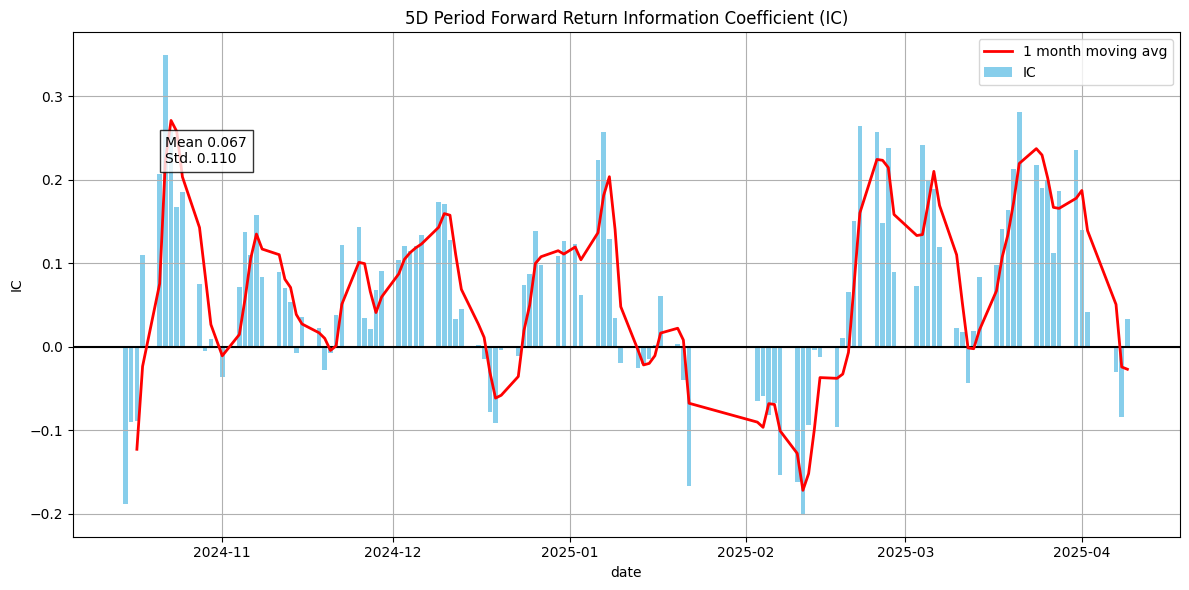

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# 計算每日 IC（Spearman）
ic_series = factor_data.groupby(level='date').apply(
    lambda df: df['factor'].corr(df['5D'], method='spearman')
)
ic_series = ic_series.reindex(dates)
# 計算 1 個月移動平均（假設交易日 = 21 天）
ic_smooth = ic_series.rolling(window=3).mean()

"""
# 畫圖
plt.figure(figsize=(12, 6))
plt.plot(ic_series.index, ic_series, label="IC", alpha=0.7)
plt.plot(ic_smooth.index, ic_smooth, label="1 month moving avg", linewidth=2)

# 畫中線
plt.axhline(0, color='black', linestyle='-')

# 標示 IC mean / std
text = f"Mean {ic_series.mean():.3f}\nStd. {ic_series.std():.3f}"
plt.text(ic_series.index[5], 0.22, text, bbox=dict(facecolor='white', alpha=0.8))

# 格式設定
plt.title("5D Period Forward Return Information Coefficient (IC)")
plt.ylabel("IC")
plt.xlabel("date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
"""

plt.figure(figsize=(12, 6))
plt.bar(ic_series.index, ic_series, label="IC", color='skyblue')
plt.axhline(0, color='black', linestyle='-')

# 加上移動平均線
plt.plot(ic_smooth.index, ic_smooth, label="1 month moving avg", color='red', linewidth=2)

# 註解與格式
text = f"Mean {ic_series.mean():.3f}\nStd. {ic_series.std():.3f}"
plt.text(ic_series.index[5], 0.22, text, bbox=dict(facecolor='white', alpha=0.8))

plt.title("5D Period Forward Return Information Coefficient (IC)")
plt.ylabel("IC")
plt.xlabel("date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
ic_smooth

Date
2024-10-15         NaN
2024-10-16         NaN
2024-10-17   -0.122901
2024-10-18   -0.023583
2024-10-21    0.075396
                ...   
2025-04-01    0.187111
2025-04-02    0.138927
2025-04-07    0.050612
2025-04-08   -0.024305
2025-04-09   -0.027037
Length: 115, dtype: float64

In [32]:
ic_series.isna().sum()

np.int64(0)

# SS

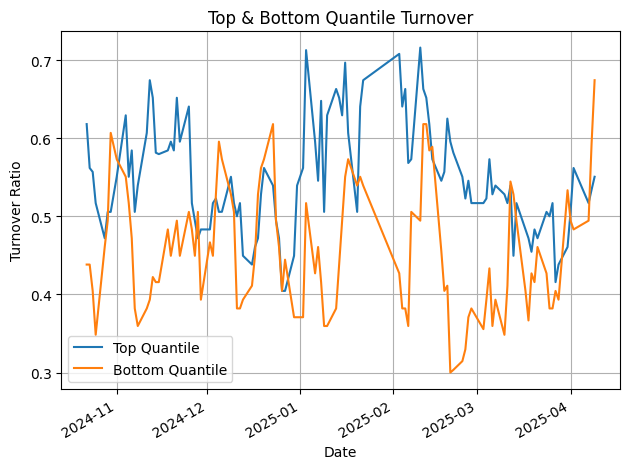

In [17]:
def compute_quantile_turnover(factor_data, period=5):
    """
    手動計算每個 quantile 的換手率（Turnover）
    factor_data: alphalens 的輸出（含 factor_quantile）
    period: 換手週期，預設為 5（交易日）
    """
    quantiles = sorted(factor_data['factor_quantile'].dropna().unique().astype(int))
    dates = sorted(factor_data.index.get_level_values("date").unique())

    turnover_dict = {q: [] for q in quantiles}
    turnover_dates = []

    for i in range(period, len(dates)):
        d_prev = dates[i - period]
        d_curr = dates[i]

        for q in quantiles:
            # 取得這個 quantile 在 t−period 和 t 的資產集合
            assets_prev = set(factor_data.xs(d_prev).query("factor_quantile == @q").index)
            assets_curr = set(factor_data.xs(d_curr).query("factor_quantile == @q").index)

            if len(assets_curr) == 0:
                turnover = np.nan
            else:
                turnover = len(assets_curr - assets_prev) / len(assets_curr)

            turnover_dict[q].append(turnover)

        turnover_dates.append(d_curr)

    # 組成 DataFrame
    turnover_df = pd.DataFrame(turnover_dict, index=turnover_dates)
    return turnover_df

turnover = compute_quantile_turnover(factor_data, period=5)

# 畫 top/bottom quantile 換手率
top_q = turnover[turnover.columns.max()]
bottom_q = turnover[turnover.columns.min()]

top_q.plot(label='Top Quantile')
bottom_q.plot(label='Bottom Quantile')
plt.title("Top & Bottom Quantile Turnover")
plt.ylabel("Turnover Ratio")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


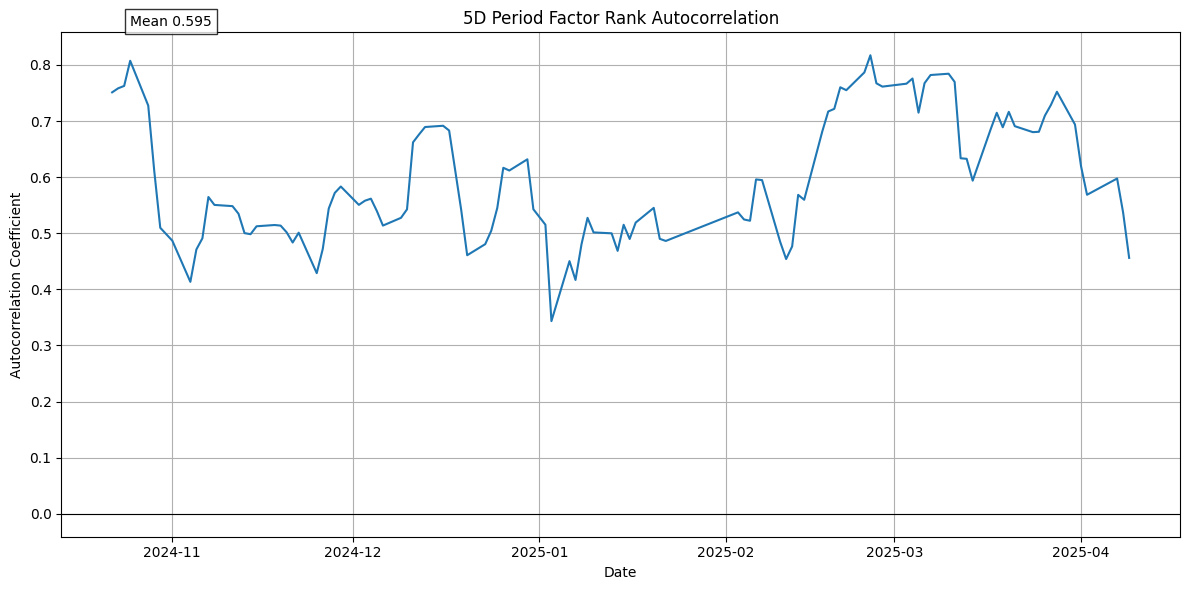

In [18]:
def compute_factor_rank_autocorrelation(factor_data, period=5):
    dates = sorted(factor_data.index.get_level_values("date").unique())
    autocorrs = []
    valid_dates = []

    for i in range(period, len(dates)):
        d_prev = dates[i - period]
        d_curr = dates[i]

        df_prev = factor_data.xs(d_prev)
        df_curr = factor_data.xs(d_curr)

        # 只保留兩天都有的股票
        common_assets = df_prev.index.intersection(df_curr.index)
        if len(common_assets) < 10:
            autocorrs.append(np.nan)
            continue

        # 排名並計算 Spearman correlation
        rank_prev = df_prev.loc[common_assets]['factor'].rank()
        rank_curr = df_curr.loc[common_assets]['factor'].rank()

        corr = rank_prev.corr(rank_curr, method='spearman')
        autocorrs.append(corr)
        valid_dates.append(d_curr)

    return pd.Series(autocorrs, index=valid_dates)
    


autocorr_series = compute_factor_rank_autocorrelation(factor_data, period=5)

plt.figure(figsize=(12, 6))
plt.plot(autocorr_series.index, autocorr_series, label="Autocorrelation")
plt.axhline(0, color='black', linewidth=0.8)

# 加上 Mean 標註
plt.text(autocorr_series.index[3], 0.87,
         f"Mean {autocorr_series.mean():.3f}",
         bbox=dict(facecolor="white", alpha=0.8))

plt.title("5D Period Factor Rank Autocorrelation")
plt.ylabel("Autocorrelation Coefficient")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
tears.create_full_tear_sheet(factor_data)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.300781,-0.133789,-0.220616,0.030366,10255,10.053429
2,-0.247559,-0.095032,-0.170526,0.036009,10237,10.035783
3,-0.234985,-0.061462,-0.132806,0.041688,10111,9.912259
4,-0.208496,-0.041199,-0.098273,0.039216,10235,10.033822
5,-0.152588,-0.030533,-0.069273,0.029041,10231,10.029900
6,-0.112671,-0.020370,-0.045956,0.015313,10129,9.929905
7,-0.062805,-0.015610,-0.033540,0.009149,10244,10.042645
8,-0.044769,-0.011421,-0.027830,0.008548,10128,9.928925
9,-0.040955,-0.006329,-0.024046,0.008972,10227,10.025979


Returns Analysis


,5D
Ann. alpha,0.096
beta,-0.066
Mean Period Wise Return Top Quantile (bps),35.863
Mean Period Wise Return Bottom Quantile (bps),-42.696
Mean Period Wise Spread (bps),78.558


C:\Users\dctp2025\.conda\envs\dc1\Lib\site-packages\alphalens\tears.py:262: UserWarning: 'freq' not set in factor_data index: assuming business day
  warnings.warn(


<Figure size 640x480 with 0 Axes>

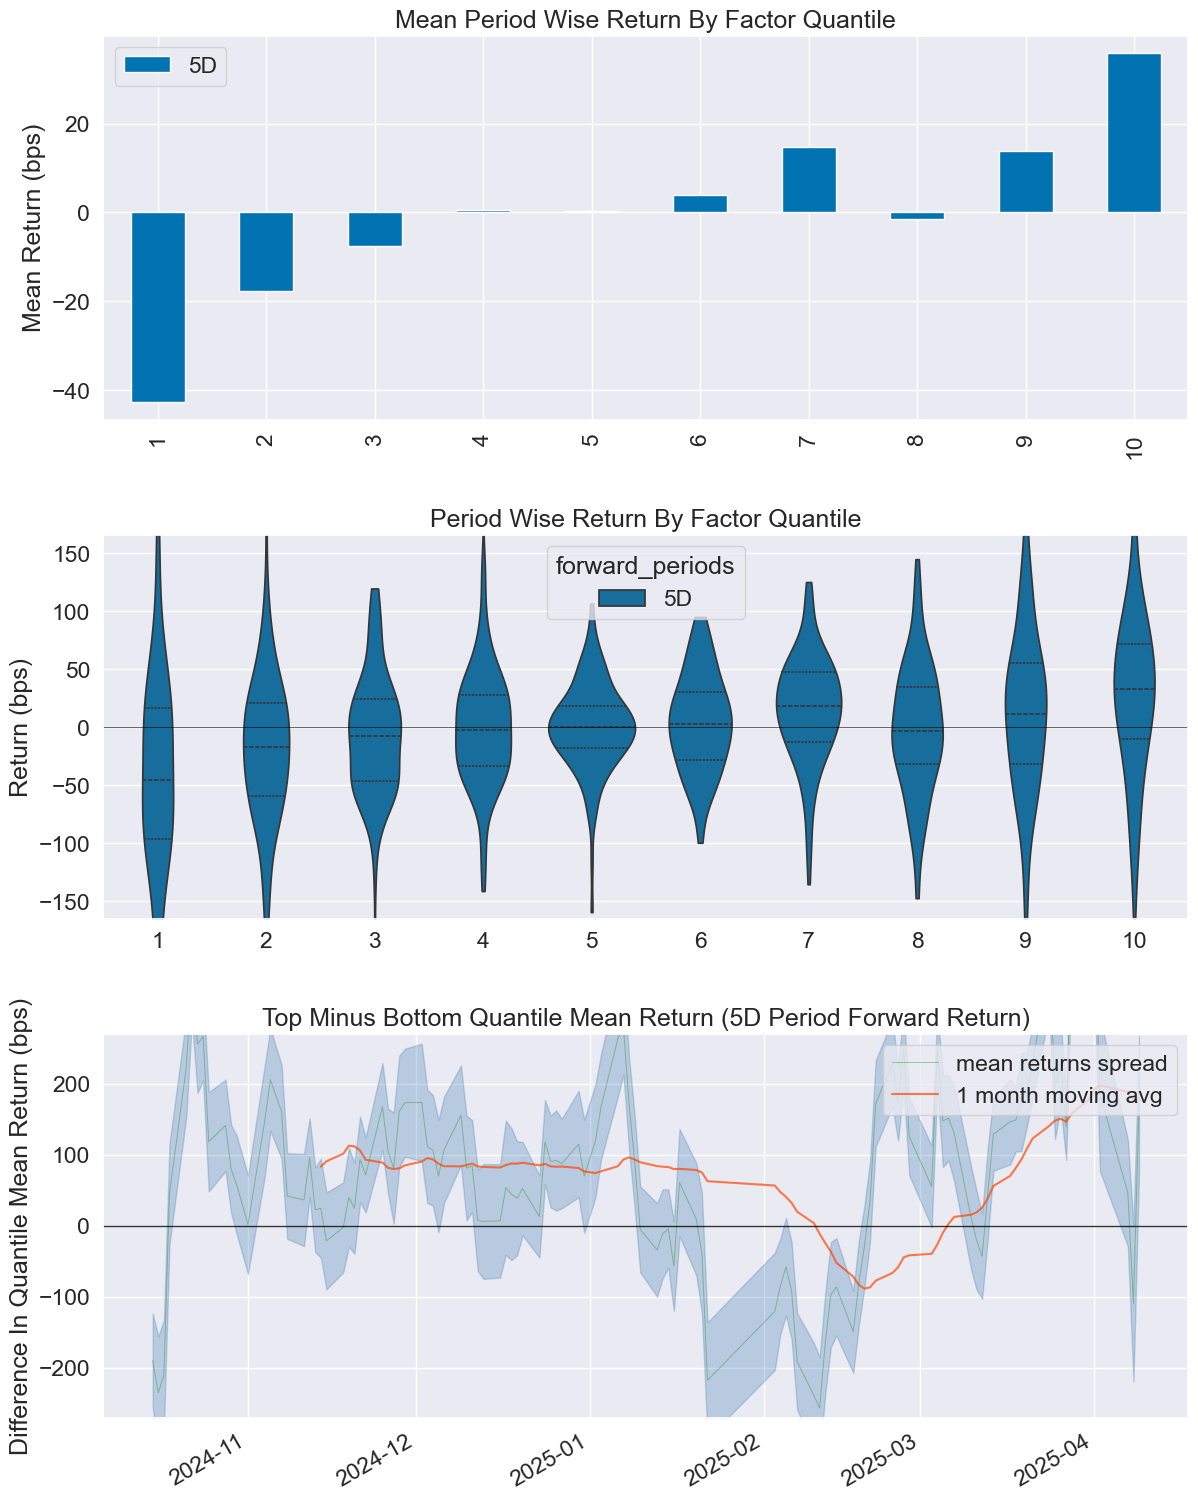

Information Analysis


,5D
IC Mean,0.067
IC Std.,0.110
Risk-Adjusted IC,0.610
t-stat(IC),NaN
p-value(IC),NaN
IC Skew,NaN
IC Kurtosis,NaN


C:\Users\dctp2025\.conda\envs\dc1\Lib\site-packages\alphalens\performance.py:118: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  grouper.append(pd.Grouper(freq=by_time))


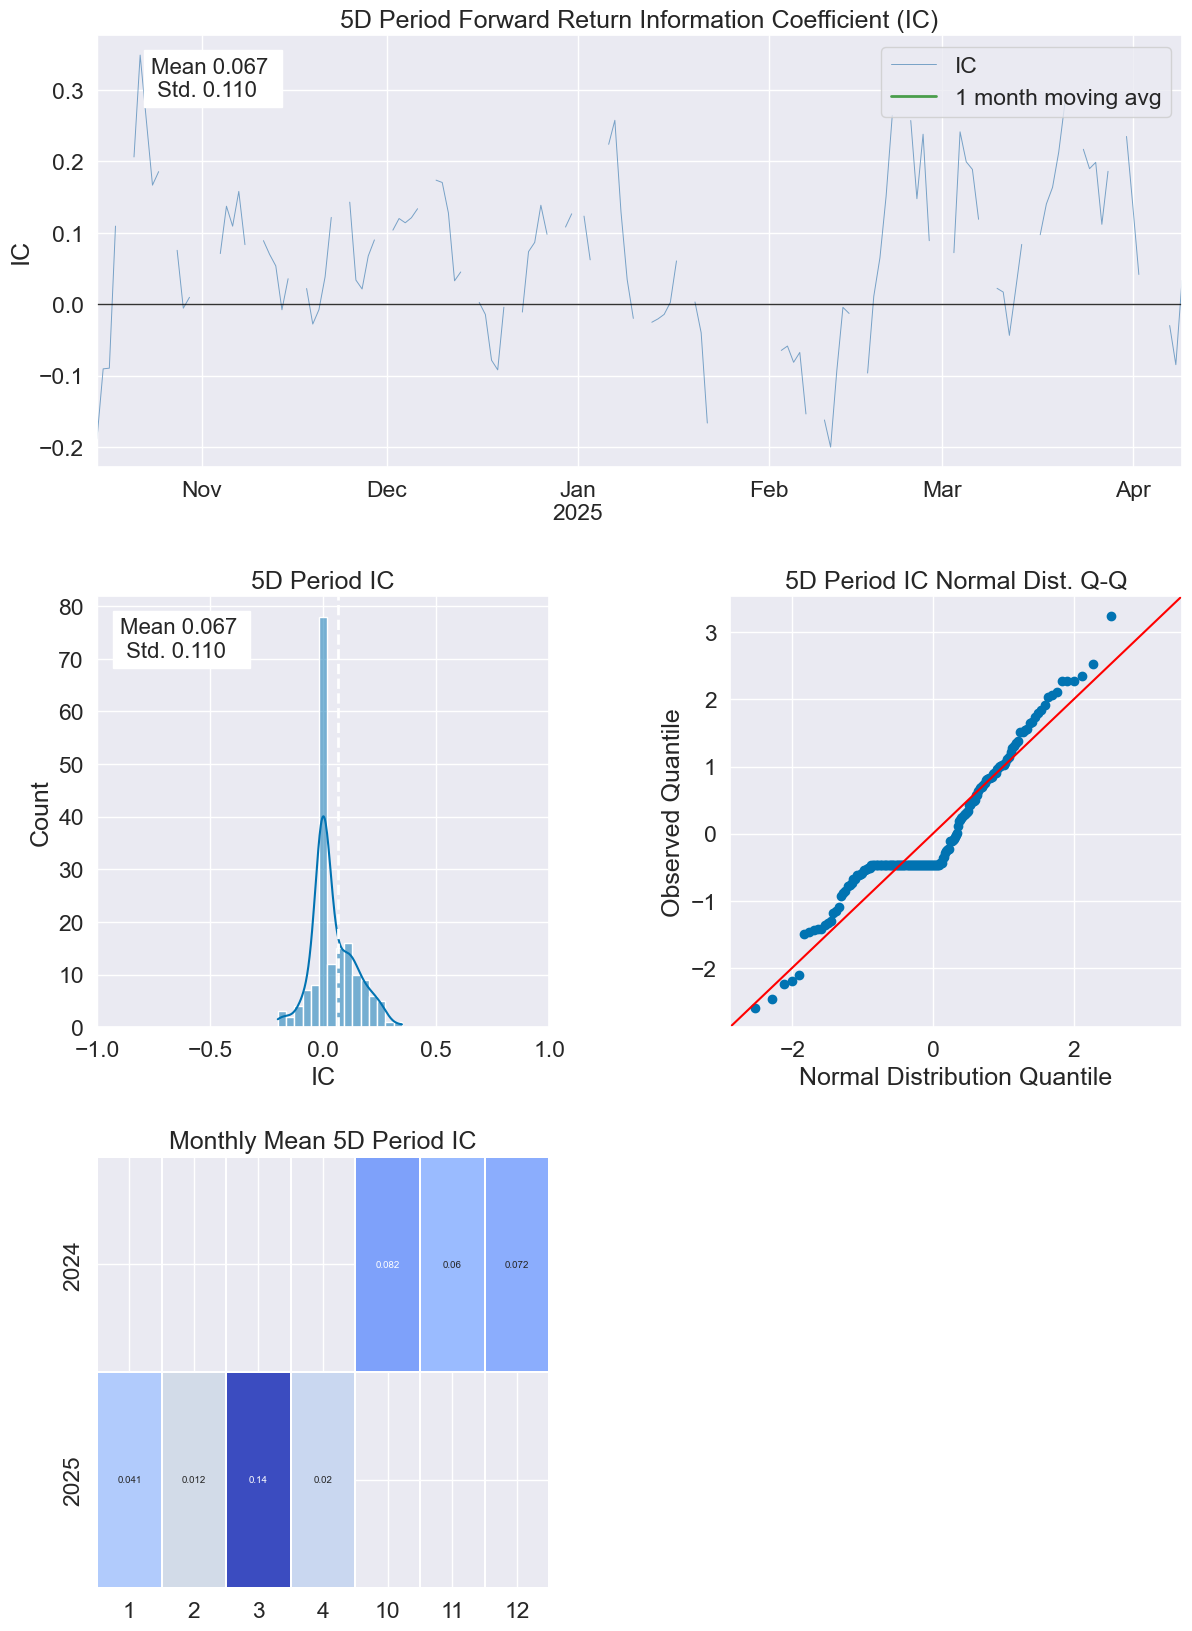

Turnover Analysis


C:\Users\dctp2025\.conda\envs\dc1\Lib\site-packages\alphalens\utils.py:928: UserWarning: Skipping return periods that aren't exact multiples of days.
  warnings.warn(


,5D
Quantile 1 Mean Turnover,0.344
Quantile 2 Mean Turnover,0.632
Quantile 3 Mean Turnover,0.715
Quantile 4 Mean Turnover,0.762
Quantile 5 Mean Turnover,0.780
Quantile 6 Mean Turnover,0.775
Quantile 7 Mean Turnover,0.741
Quantile 8 Mean Turnover,0.695
Quantile 9 Mean Turnover,0.627
Quantile 10 Mean Turnover,0.399


,5D
Mean Factor Rank Autocorrelation,0.743


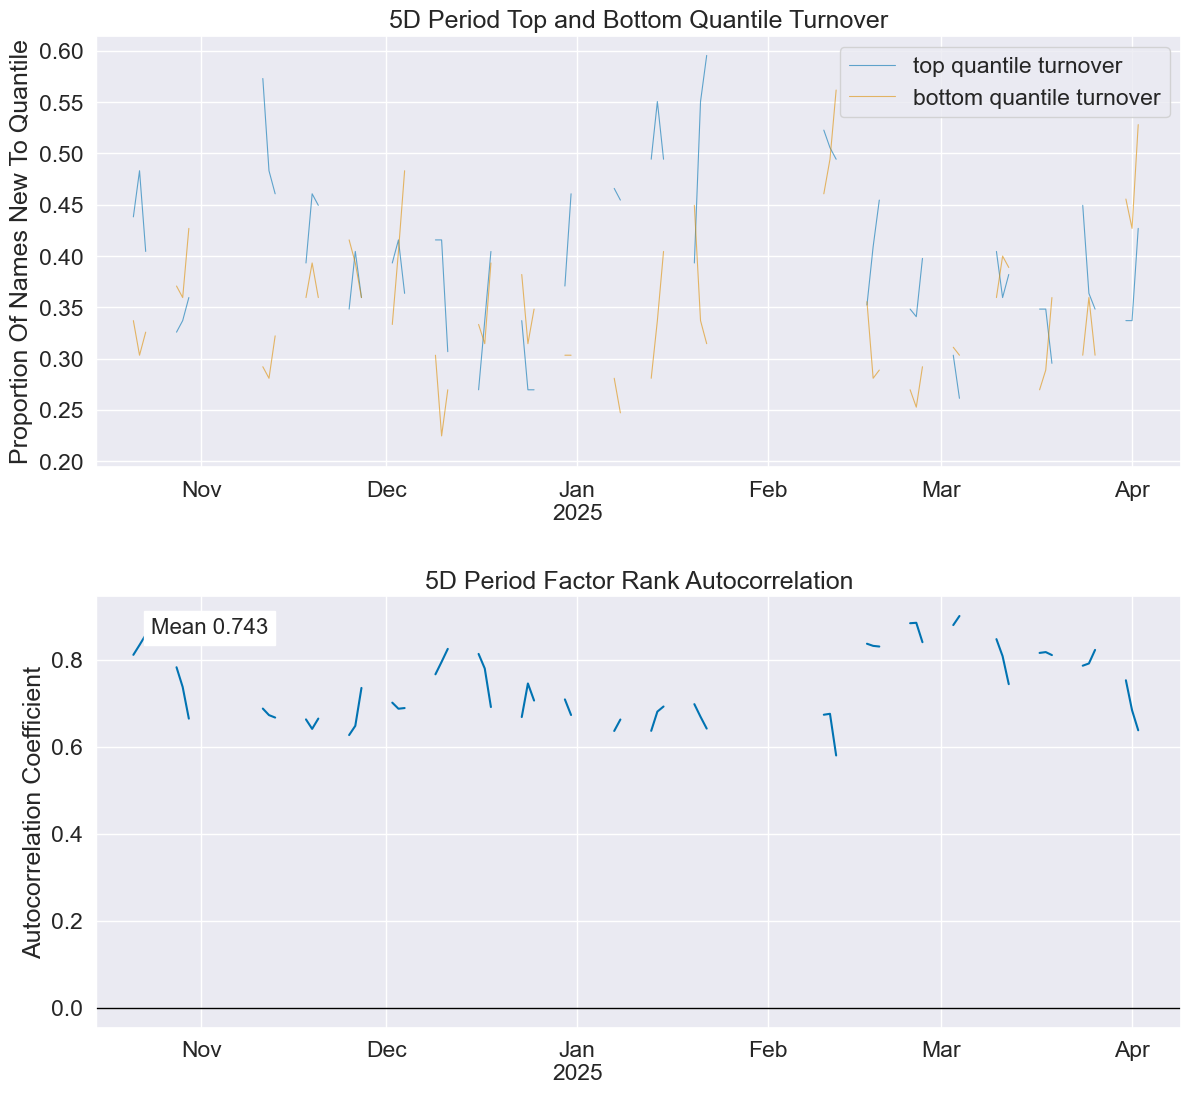

In [58]:
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter

model = MASTER(market_dim=21, feature_dim=186, embed_dim=256, nhead1=4, nhead2=2, beta=2).to(device)
state_dict = torch.load("MASTER_best_model.pt", weights_only=True)
model.load_state_dict(state_dict)

model.eval()  # 設定為評估模式（關閉 dropout、batchnorm）

factors, market, returns = test_set.tensor_factor, test_set.tensor_market, test_set.tensor_return
factors, market = factors.to(device), market.to(device)

lookback = 8
valid_length = len(market) - lookback



cum = 1
long_cum = 1
short_cum = 1

cum_list = []
long_cum_list = []
short_cum_list = []


with torch.no_grad():
    for idx in range(valid_length):
        X = factors[ : , idx:idx+lookback, : ] # (stock, time, factor)
        M = market[idx+lookback-1, : ]

        X = X.unsqueeze(0) # (batch=1, stock, time, factor)
        M = M.unsqueeze(0) # (batch=1, feature)
        ret = returns[idx+lookback-1, : ]
        #print(X.shape, M.shape, ret.shape)
        
        
        with autocast('cuda', dtype=torch.float16):
            logits = model(X, M)
            logits = logits.squeeze()
            logits = logits.cpu()
            #print(logits.shape)
        top_indices = torch.topk(logits, 30, largest=True).indices
        bottom_indices = torch.topk(logits, 30, largest=False).indices

        long = ret[top_indices]
        short = ret[bottom_indices]
        combined = torch.cat([long, -short], dim=0)  # shape: [60]


        cum = cum + torch.mean(combined).item()
        long_cum = long_cum + torch.mean(long).item()
        short_cum = short_cum + torch.mean(-short).item()

        
        cum_list.append(cum)
        long_cum_list.append(long_cum)
        short_cum_list.append(short_cum)
        
        



   


In [59]:
len(test_set.TPEX_df.index[8:])

114

In [35]:
plt.plot(test_set.TPEX_df.index[8:], cum_list)

NameError: name 'cum_list' is not defined

In [34]:
plt.plot(test_set.TPEX_df.index[8:], cum_list/5)

NameError: name 'cum_list' is not defined

# 多空圖

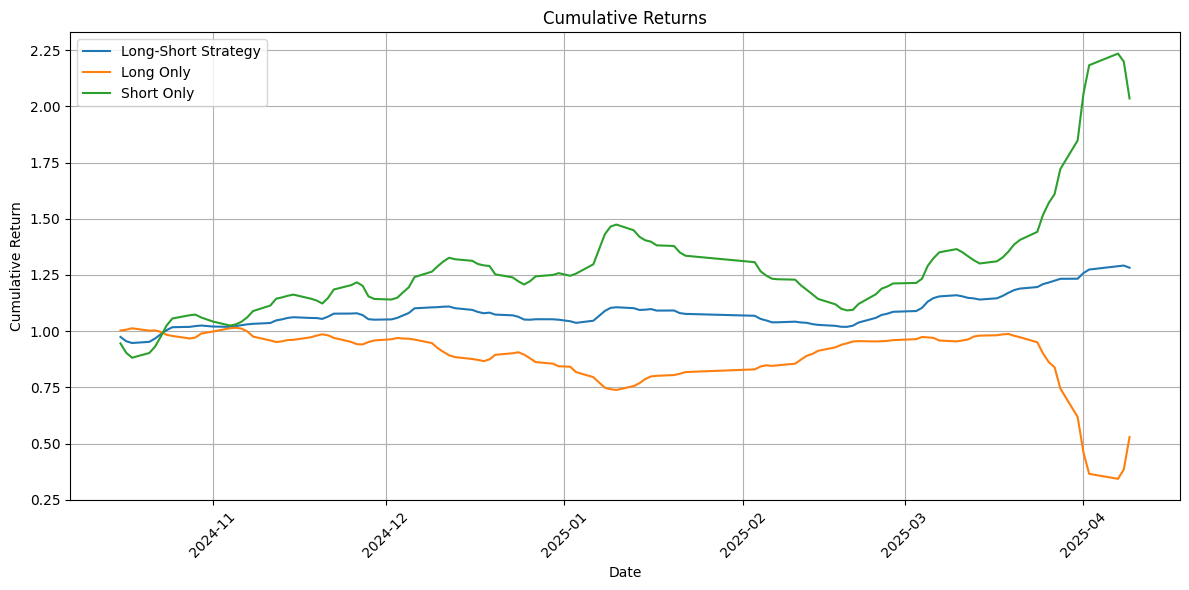

In [61]:
import matplotlib.pyplot as plt

dates = test_set.TPEX_df.index[8:]  # 對應 lookback=8 之後的日期

plt.figure(figsize=(12, 6))
plt.plot(dates, cum_list, label='Long-Short Strategy')
plt.plot(dates, long_cum_list, label='Long Only')
plt.plot(dates, short_cum_list, label='Short Only')

plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 計算Quantile

In [68]:
import torch
import numpy as np

num_quantiles = 10
quantile_cum_returns = [1.0 for _ in range(num_quantiles)]
quantile_cum_list = [[] for _ in range(num_quantiles)]

with torch.no_grad():
    for idx in range(valid_length):
        X = factors[:, idx:idx+lookback, :]
        M = market[idx+lookback-1, :]
        ret = returns[idx+lookback-1, :]

        X = X.unsqueeze(0)
        M = M.unsqueeze(0)

        with autocast('cuda', dtype=torch.float16):
            logits = model(X, M).squeeze().cpu()  # 模型打分 (N,)
        
        # 分數排序，取得每一層的 index
        scores_np = logits.numpy()
        sorted_indices = np.argsort(scores_np)
        total_stocks = len(scores_np)
        stocks_per_quantile = total_stocks // num_quantiles

        for q in range(num_quantiles):
            start = q * stocks_per_quantile
            end = (q + 1) * stocks_per_quantile if q != num_quantiles - 1 else total_stocks
            quantile_indices = sorted_indices[start:end]

            # 計算該 quantile 當天平均報酬 
            q_ret = ret[quantile_indices]
            avg_q_ret = q_ret.mean().item()

            # 更新累積報酬
            quantile_cum_returns[q] += avg_q_ret
            quantile_cum_list[q].append(quantile_cum_returns[q])


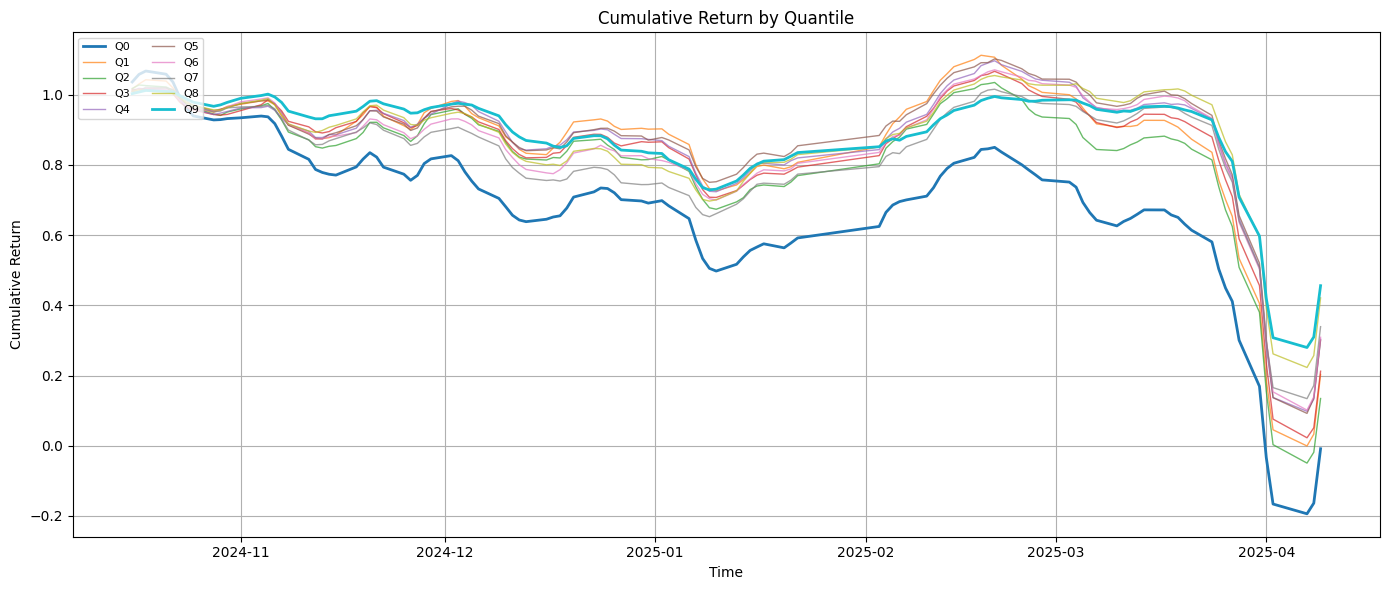

In [74]:
import matplotlib.pyplot as plt

# quantile_cum_list 是一個長度為 num_quantiles 的 list，每個元素是每天的累積報酬序列
# 假設你已經有 quantile_cum_list，可以直接畫圖
num_quantiles = len(quantile_cum_list)

plt.figure(figsize=(14, 6))
for i in range(num_quantiles):
    plt.plot(dates, quantile_cum_list[i], label=f'Q{i}', alpha=0.7 if i not in [0, num_quantiles-1] else 1.0,
             linewidth=2 if i in [0, num_quantiles-1] else 1)

plt.title("Cumulative Return by Quantile")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend(loc="upper left", ncol=2, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()
